In [5]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import networkx as nx
import glob


In [62]:


class MTBLSDataset:
    '''
    Class to load and QC metabolon data
    '''
    def __init__(self, file_path, id, node_name, md_group, md_filter):
        self.file_path = file_path
        self.raw_data = None
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.md_group = md_group
        self.md_filter = md_filter
        self.DA_metabolites = None

        self.read_data(file_path)
        self.preprocess_data()
        # self.da_testing()
        
    def read_data(self, file_path):
        """
        Read in the metabolights format data
        """
        # read in the maf files
        files = glob.glob(file_path + '/*_maf.tsv')
        # for now only use one maf file

        data = pd.read_csv(files[0], sep='\t')
        self.raw_data = data

        metadata = pd.read_csv(file_path + '/s_' + self.id + '.txt', sep = '\t')

        self.metadata = metadata
        self.metadata['Sample Name'] = self.metadata['Sample Name'].astype(str)
        print(metadata[['Sample Name', 'Factor Value[Disease]']].head())

        return data, metadata

    def preprocess_data(self):
        data_filt = self.raw_data.copy()

        # set chebi as index
        data_filt = data_filt[data_filt['database_identifier'].notna()]
        data_filt.index = data_filt['database_identifier']

        # keep only abundance data filtering on samples
        samples = self.metadata['Sample Name'].tolist()
        data_filt = data_filt[samples]


        # ensure all data is numeric
        data_filt = data_filt.apply(pd.to_numeric, errors='coerce')

        # Transpose
        data_filt = data_filt.T

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' '], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        data_filt = data_filt.dropna(axis=1, thresh=0.3*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        # add metadata column
        md_dict = dict(zip(self.metadata['Sample Name'], self.metadata[self.md_group]))
        data_scaled['Group'] = data_scaled.index.map(md_dict)


    #     # filter on metadata
    #     # TODO check whether to rescale after filtering
    #     data_scaled = data_scaled[data_scaled['Group'].isin(self.md_filter)]

        # rescale data
        data_rescaled = data_scaled.iloc[:, :-1].apply(lambda x: (x - x.mean()) / x.std())
        data_rescaled['Group'] = data_scaled['Group']

        self.processed_data = data_rescaled

        return data_rescaled
    
    def plot_qc(self):
        
        # PCA biplot
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result[:, 0], y=pca_result[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = 10 * self.processed_data.shape[1]
        data_long = self.processed_data.melt(id_vars='Group')
        sns.boxplot(data=data_long.iloc[0:normaliser, :], ax=ax2, hue='Group', x='variable', y='value')
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()

    # def da_testing(self):

    #     # t-test for two groups
    #     groups = self.processed_data['Group'].unique()
    #     stat, pvals = stats.ttest_ind(self.processed_data[self.processed_data['Group'] == groups[0]].iloc[:, :-1],
    #                     self.processed_data[self.processed_data['Group'] == groups[1]].iloc[:, :-1],
    #                     alternative='two-sided')
    #     pval_df = pd.DataFrame(pvals, index=self.processed_data.columns[:-1], columns=['P-value'])

    #     # fdr correction 
    #     pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

    #     # return significant metabolites
    #     self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
    #     print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

    #     # generate tuples for nx links
    #     self.connection = [(self.node_name, met) for met in self.DA_metabolites]

    # def get_class_info(self, hmdbs=None):

    #     if hmdbs == None:
    #         hmdbs = self.compound_mappers['HMDB'].tolist()
    #     hmdb_ids = ['hmdb:' + str(hmdb) for hmdb in hmdbs if not pd.isna(hmdb)]
    #     print(hmdb_ids)
    #     api_url = "https://rampdb.nih.gov/api/chemical-classes"
    #     request_body = {
    #     "metabolites": hmdb_ids
    #     }
    #     response = requests.post(api_url, json=request_body, verify=False)
    #     resp_json = response.json()['data']
    #     resp_df = pd.DataFrame.from_dict(resp_json)
    #     return resp_df
    




In [63]:
s2014 = MTBLSDataset(
    file_path = 'Studies/MTBLS2014', 
    id = 'MTBLS2014', 
    node_name = 'MTBLS2014', 
    md_group = 'Factor Value[Disease]', 
    md_filter = ['Healthy', 'Patient (+) SARS-CoV-2'])

                Sample Name   Factor Value[Disease]
0  03JUN2020_COV_AAA_PL_021                 Healthy
1  03JUN2020_COV_AAA_PL_024                 Healthy
2  03JUN2020_COV_AAA_PL_029  Patient (+) SARS-CoV-2
3  03JUN2020_COV_AAA_PL_032  Patient (+) SARS-CoV-2
4  03JUN2020_COV_AAA_PL_035  Patient (+) SARS-CoV-2
Missingness: 0.00%


In [66]:
s2014.processed_data.shape

(49, 32)

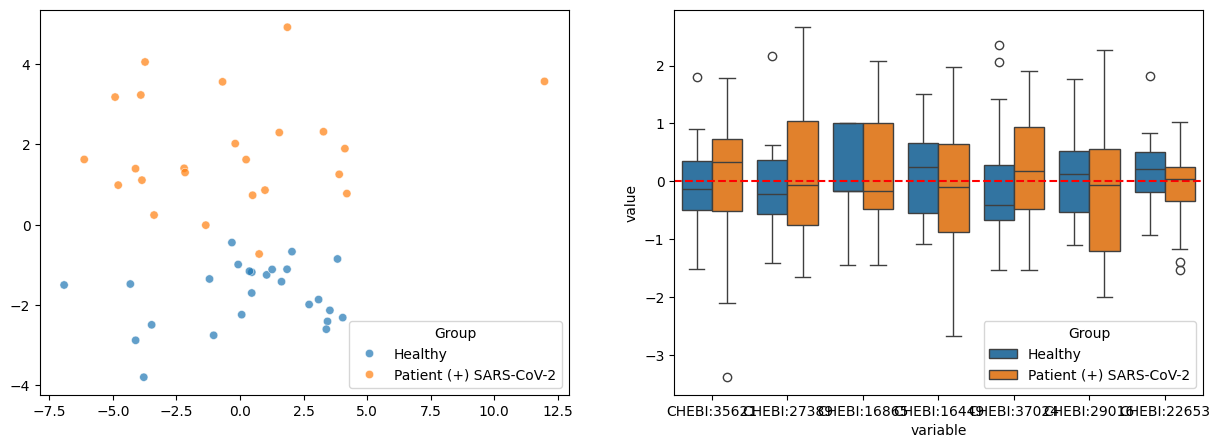

In [64]:
s2014.plot_qc()